# PanSTARRS - WISE crossmatch: Pre-configure the ML parameters

In this step we will prepare the auxiliary variables used for the ML

In [1]:
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
import pickle

In [2]:
from mltier1 import get_center, Field

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
field = Field(170.0, 190.0, 45.5, 56.5)

## Load the data

### Load the catalogues

In [5]:
panstarrs = Table.read("panstarrs_u1.fits")

In [6]:
wise = Table.read("wise_u1.fits")

### Coordinates

As we will use the coordinates to make a cross-match we to load them

In [7]:
coords_panstarrs = SkyCoord(panstarrs['raMean'], panstarrs['decMean'], unit=(u.deg, u.deg), frame='icrs')

In [8]:
coords_wise = SkyCoord(wise['raWise'], wise['decWise'], unit=(u.deg, u.deg), frame='icrs')

## Compute the ML parameters

### Number of sources per magnitude in i-band

In [9]:
bin_list = np.linspace(12., 30., 1801)

In [10]:
center = get_center(bin_list)

In [11]:
n_hist, bins_hist = np.histogram(panstarrs["i"], bin_list)
n_m = np.cumsum(n_hist)/field.area

Number of sources per magnitude per unit area in the selected region (cumulative distribution). This sets the number of background sources. The units of this are N/(square arcsec) per magnitude.

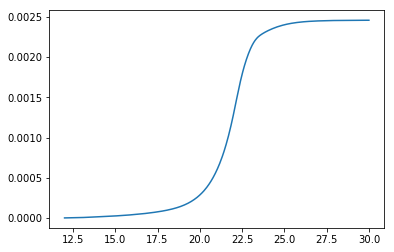

In [12]:
plot(center, n_m);

### Compute real(m) and q(m)

The first step is to crossmatch the catalogues to make an estimation

In [13]:
radius = 5 # arcseconds

In [14]:
idx_wise, idx_panstarrs, d2d, d3d = search_around_sky(
    coords_wise, coords_panstarrs, radius*u.arcsec)

The number of matched WISE sources

In [15]:
n_xm_wise = len(np.unique(idx_wise))

In [16]:
n_xm_wise

1475805

In [17]:
idx = np.unique(idx_panstarrs)

In [18]:
n_hist_total, bins_hist_total = np.histogram(panstarrs["i"][idx], bin_list)
real_m = n_hist_total - n_xm_wise*n_m*np.pi*(radius/3600.)**2

The values that are slightly below 0 due to the low numbers statistical variance are rounded to 0.

In [19]:
real_m[real_m <= 0.] = 0.

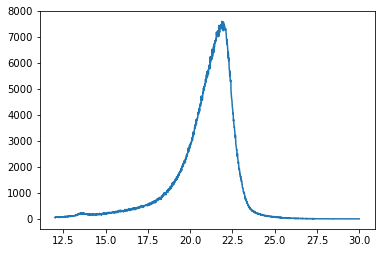

In [20]:
plot(center, real_m);

In [21]:
real_m_cumsum = np.cumsum(real_m)
q_m = real_m_cumsum/real_m_cumsum[-1]

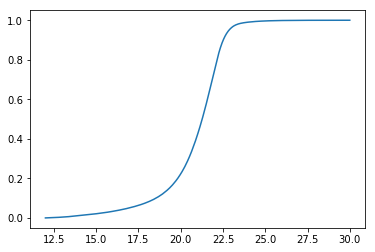

In [22]:
plot(center, q_m);

In [24]:
q0 = 0.62

## Save the parameters

In [25]:
pickle.dump([bin_list, center, q0, n_m, q_m], open("pw_params.pckl", 'wb'))